In [564]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer, SimpleImputer
import utils 

In [565]:
# Reload utils.py
importlib.reload(utils)

<module 'utils' from '/Users/mariananeves/Documents/projects/defaulting_clients/src/utils.py'>

In [566]:
# sns.set_theme(style='whitegrid')
plt.style.use('ggplot')

In [567]:
# Get the current working directory (where the notebook is being run)
base_folder = Path.cwd()
# Define the relative path to the 'raw_data' folder by going up one directory
raw_folder = base_folder.parent / 'data/raw_data'
clean_folder = base_folder.parent / 'data/clean_data'
# Load the data files
df_cad = pd.read_csv(f'{raw_folder}/base_cadastral.csv')
df_info = pd.read_csv(f'{raw_folder}/base_info.csv')
df_pag_train = pd.read_csv(f'{raw_folder}/base_pagamentos_desenvolvimento.csv')
df_pag_test = pd.read_csv(f'{raw_folder}/base_pagamentos_teste.csv')

In [568]:
datasets = [df_cad, df_info, df_pag_train, df_pag_test]
dataset_names = ['Tabela cadastral', 'Tabela info', 'Tabela Pagamentos (treino)', 'Tabela Pagamentos (teste)']

for i, (ds_name, ds) in enumerate(zip(dataset_names, datasets)):
    h0 = ds.shape[0]
    duplicated_data = ds[ds.duplicated()]
    print(f'{ds_name}\nTotal of records: {ds.shape[0]}')
    ds = ds.drop(duplicated_data.index).copy()
    h1 = ds.shape[0]
    if (h0-h1) != 0:
        print(f'{h0-h1} duplicated records successfully removed.')
    else:
        print(f'There are no duplicated records.')
    print(f'{ds.columns}\n')
    datasets[i] = ds


Tabela cadastral
Total of records: 1315
There are no duplicated records.
Index(['ID_CLIENTE', 'DATA_CADASTRO', 'DDD', 'FLAG_PF', 'SEGMENTO_INDUSTRIAL',
       'DOMINIO_EMAIL', 'PORTE', 'CEP_2_DIG'],
      dtype='object')

Tabela info
Total of records: 24401
There are no duplicated records.
Index(['ID_CLIENTE', 'SAFRA_REF', 'RENDA_MES_ANTERIOR', 'NO_FUNCIONARIOS'], dtype='object')

Tabela Pagamentos (treino)
Total of records: 77414
There are no duplicated records.
Index(['ID_CLIENTE', 'SAFRA_REF', 'DATA_EMISSAO_DOCUMENTO', 'DATA_PAGAMENTO',
       'DATA_VENCIMENTO', 'VALOR_A_PAGAR', 'TAXA'],
      dtype='object')

Tabela Pagamentos (teste)
Total of records: 12275
11 duplicated records successfully removed.
Index(['ID_CLIENTE', 'SAFRA_REF', 'DATA_EMISSAO_DOCUMENTO', 'DATA_VENCIMENTO',
       'VALOR_A_PAGAR', 'TAXA'],
      dtype='object')



In [569]:
print(df_cad['FLAG_PF'].unique())
# Drop FLAG_PF == 'X'
df_cad = df_cad.drop(df_cad[df_cad['FLAG_PF']=='X'].index).copy()
print(df_cad[df_cad['FLAG_PF']=='X'].shape[0])
df_cad = df_cad.drop(columns=['FLAG_PF']).copy()

[nan 'X']
0


In [570]:
for ds_name, ds in zip(dataset_names, datasets):
    if ds.isna().sum().sum() != 0:
        print('Table(s) with missing values:')
        print(ds_name)

Table(s) with missing values:
Tabela cadastral


# <span style="color:orange">**1. Table 'Cadastral'**</span>

In [571]:
# # Convert DATA_CADASTRO to datetime format
df_cad['DATA_CADASTRO'] = pd.to_datetime(df_cad['DATA_CADASTRO'])
df_cad.columns

Index(['ID_CLIENTE', 'DATA_CADASTRO', 'DDD', 'SEGMENTO_INDUSTRIAL',
       'DOMINIO_EMAIL', 'PORTE', 'CEP_2_DIG'],
      dtype='object')

In [572]:
df_cad.isna().sum()

ID_CLIENTE               0
DATA_CADASTRO            0
DDD                    210
SEGMENTO_INDUSTRIAL     17
DOMINIO_EMAIL           29
PORTE                   39
CEP_2_DIG                0
dtype: int64

In [573]:
# Check if there is any client that appeares more than once:
df_cad.shape[0] == np.size(df_cad['ID_CLIENTE'].unique())

True

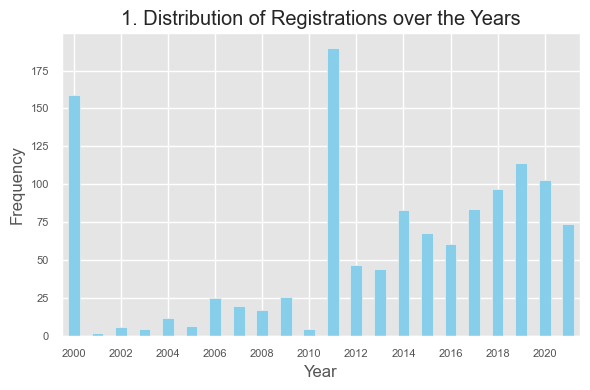

In [574]:
# Plot the distribution of 'DATA_CADASTRO' 
plt.figure(figsize=(6, 4))
ax = df_cad['DATA_CADASTRO'].dt.year.value_counts().sort_index().plot(kind='bar', color='skyblue')
ax.set_title('1. Distribution of Registrations over the Years')
ax.set_xlabel('Year')
ax.set_ylabel('Frequency')
ax.set_xticks(ax.get_xticks()[::2])# Adjust x-axis ticks to show every second year
plt.xticks(rotation=0, size=8)
plt.yticks(size=8)
plt.tight_layout()
plt.show()

    Plot '1. Distribution of Registrations over the Years' shows that registration peaks occurred in 2000 and 2011, with 2000 being the beginning of the historical series. Coincidence or not, these peaks occurred close to global crises: the DotCom Crisis (2000-2002), the Subprime Crisis (2008), and the European Sovereign Debt Crisis (2010-2012).

In [575]:
print('Table "Cadastral"\nPercentage of missing values\n')
for column in df_cad.columns:
    nulls = df_cad[column].isna().sum()
    if nulls != 0:
        percent = 100-(((df_cad.shape[0]- nulls)/df_cad.shape[0])*100)
        print(f'{column} = {percent:.2f}')

Table "Cadastral"
Percentage of missing values

DDD = 16.81
SEGMENTO_INDUSTRIAL = 1.36
DOMINIO_EMAIL = 2.32
PORTE = 3.12


In [576]:
df_cad.isna().sum()

ID_CLIENTE               0
DATA_CADASTRO            0
DDD                    210
SEGMENTO_INDUSTRIAL     17
DOMINIO_EMAIL           29
PORTE                   39
CEP_2_DIG                0
dtype: int64

    We can retrieve information about location from both 'CEP_2_DIG' and 'DDD'. Since column 'CEP_2_DIG' has less missing information, we will start with it.



In [577]:
# Make the data more uniform 
df_cad = df_cad.replace({'PEQUENO': 'Pequeno', 'MEDIO': 'Médio', 'GRANDE': 'Grande'}).copy()

### <span style="color:orange">**1.1 Column 'CEP_2_DIG'**</span>

In [578]:
df_cad['CEP_2_DIG'] = pd.to_numeric(df_cad['CEP_2_DIG'], errors='coerce')
df_cad['CEP_2_DIG'].unique()

array([65., 77., 48., 89., 62., 19., 38., 26., 55., 87., 37., 22., 13.,
       18., 21., 98., 14., 60., 82., 92., 79., 12., 27., 76., 67., 72.,
       68., 11., 84., 70., 83., 88., 75., 36., 45., 44., 16., 42., 78.,
       31., 41., 35., 51., 30., 86., 25., 29., 17., 23., 20., 93., 64.,
       95., 85., 15., 99., 80., 24., 61., 90., 50., 96., 97., 57., 46.,
       47., 32., 54., 91., 56., 28., 71., 33., 94., 58., 34., 59., 69.,
       74., 40., 49., 43., 66., 39., 73., 81., 53., 52., 63., nan])

In [579]:
# Check the null value in 'CEP_2_DIG'
df_cad[df_cad['CEP_2_DIG'].isna()]

,ID_CLIENTE,DATA_CADASTRO,DDD,SEGMENTO_INDUSTRIAL,DOMINIO_EMAIL,PORTE,CEP_2_DIG
934,3903290047715748290,2019-10-07,NaN,Indústria,HOTMAIL,Pequeno,NaN


In [580]:
# Call the function to add the 'STATE' and 'REGION' columns based on 'CEP_2_DIG'
df_cad = utils.add_state_region(df_cad, f'{base_folder}/state_region_info.json')

# Since we created the columns 'ESTADO' and 'REGION', we can drop 'CEP_2_DIG' and 'DDD' and other unecessary columns
df_cad = df_cad.drop(columns=['DDD', 'CEP_2_DIG', 'DOMINIO_EMAIL', 'DATA_CADASTRO']).copy()

# Check the result
df_cad.columns

Index(['ID_CLIENTE', 'SEGMENTO_INDUSTRIAL', 'PORTE', 'ESTADO', 'REGIAO'], dtype='object')

### <span style="color:orange">**1.2 Columns 'REGIAO' & 'ESTADO'**</span>

In [581]:
# Check of records with missing values in 'REGIAO' or 'ESTADO'
df_cad[df_cad['ESTADO'].isna() | df_cad['REGIAO'].isna()]

,ID_CLIENTE,SEGMENTO_INDUSTRIAL,PORTE,ESTADO,REGIAO
934,3903290047715748290,Indústria,Pequeno,NaN,NaN


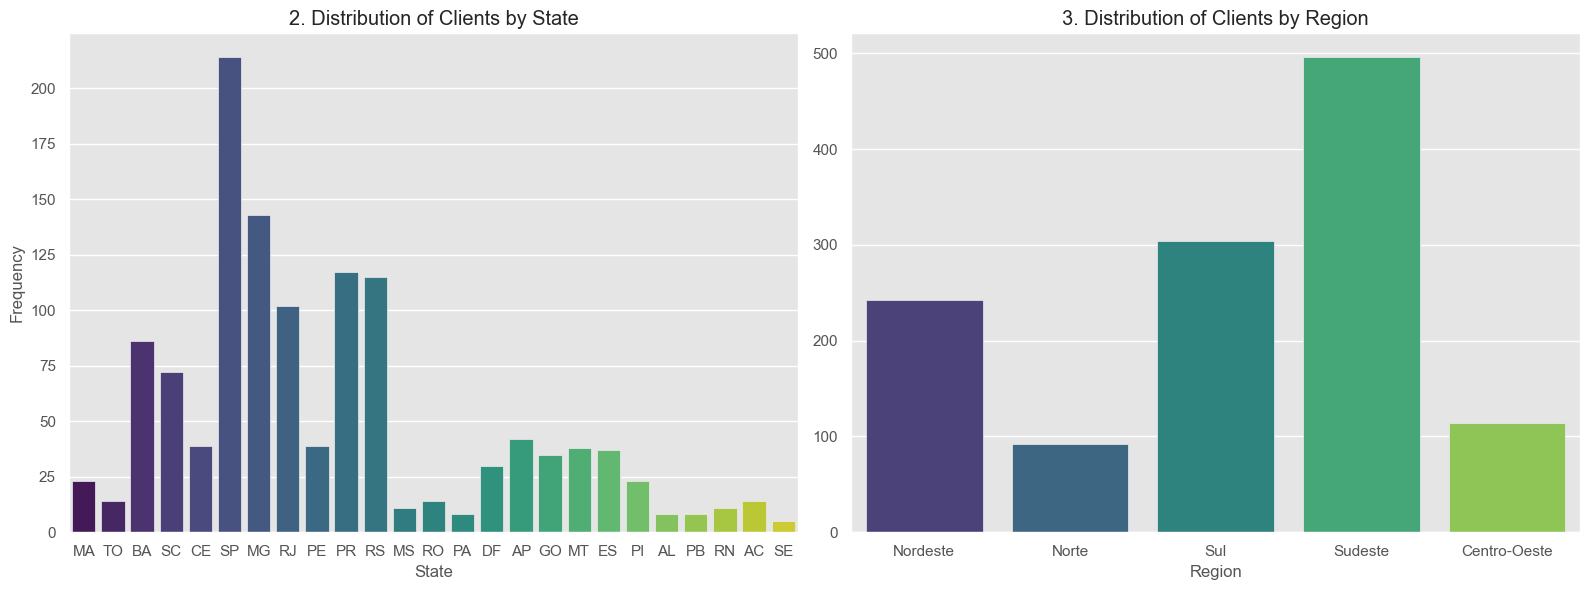

In [582]:
# Create subplots for both plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: SEGMENTO_INDUSTRIAL vs REGIAO
sns.countplot(x='ESTADO', hue='ESTADO', data=df_cad, ax=axes[0], palette='viridis', legend=False)
axes[0].set_title('2. Distribution of Clients by State')
axes[0].set_xlabel('State')
axes[0].set_ylabel('Frequency')

# Plot 2: PORTE vs REGIAO
sns.countplot(x='REGIAO', hue='REGIAO', data=df_cad, ax=axes[1], palette='viridis', legend=False)
axes[1].set_title('3. Distribution of Clients by Region')
axes[1].set_xlabel('Region')
axes[1].set_ylabel('')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

Plots 2 and 3 show that the most frequent state is 'SP' and the most frequent region is 'Sudeste'. Since the margin for the 2nd places are quite big, we'll replace the missing record with 'SP' for 'ESTADO' and 'SUDESTE' for 'REGIAO'.

In [583]:
idx_null = df_cad[df_cad['ESTADO'].isna() | df_cad['REGIAO'].isna()].index
df_cad[df_cad['ESTADO'].isna() | df_cad['REGIAO'].isna()]

,ID_CLIENTE,SEGMENTO_INDUSTRIAL,PORTE,ESTADO,REGIAO
934,3903290047715748290,Indústria,Pequeno,NaN,NaN


In [584]:
# Create the imputer for categorical data, using the most frequent value
cat_imputer = SimpleImputer(strategy='most_frequent')

# Fit and transform the selected columns and assign back to the DataFrame
df_cad[['ESTADO', 'REGIAO']] = cat_imputer.fit_transform(df_cad[['ESTADO', 'REGIAO']])

# Check if the record had missing values replaced
df_cad[df_cad.index == idx_null[0]]

,ID_CLIENTE,SEGMENTO_INDUSTRIAL,PORTE,ESTADO,REGIAO
934,3903290047715748290,Indústria,Pequeno,SP,Sudeste


### <span style="color:orange">**1.3 Columns 'PORTE' & 'SEGMENTO_INDUSTRIAL'**</span>

    Plots 4 and 5 show that the service segment has the highest frequency for all regions and segments and most of the clients are medium-sized.


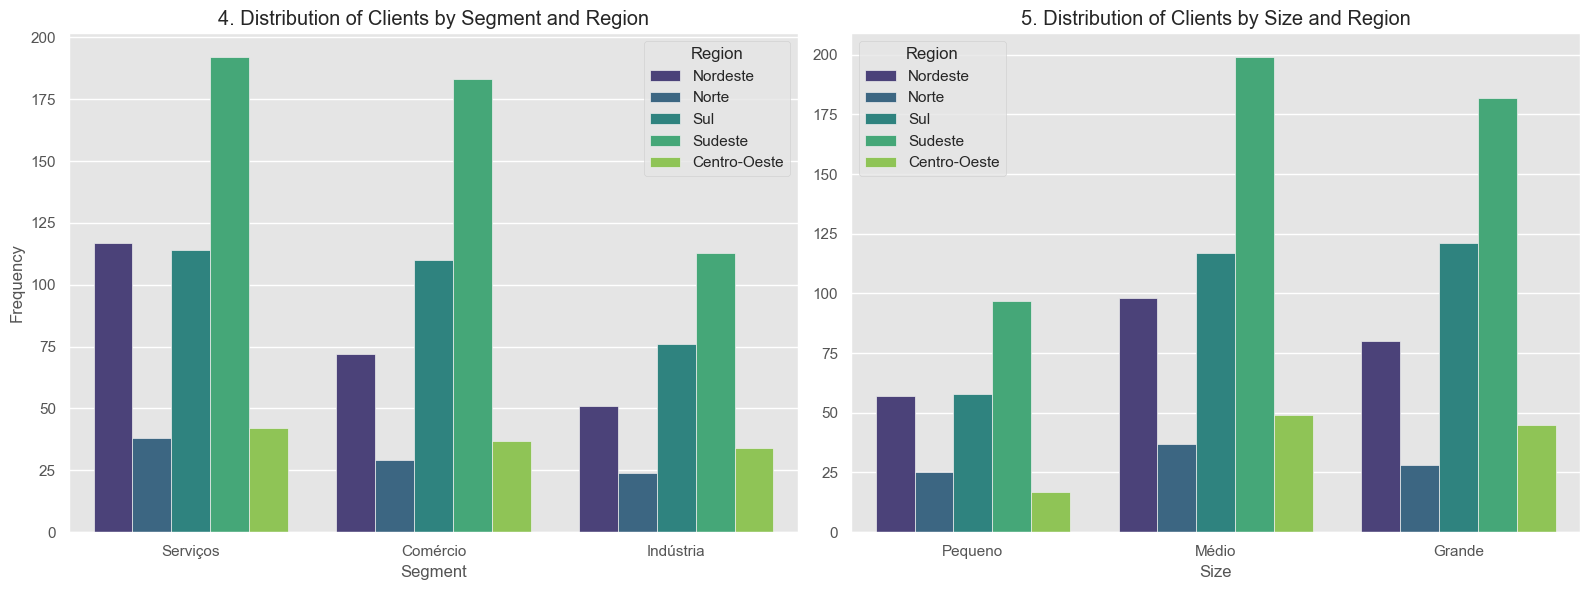

In [585]:
# Create subplots for both plots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: SEGMENTO_INDUSTRIAL vs REGIAO
sns.countplot(x='SEGMENTO_INDUSTRIAL', hue='REGIAO', data=df_cad, ax=axes[0], palette='viridis')
axes[0].set_title('4. Distribution of Clients by Segment and Region')
axes[0].set_xlabel('Segment')
axes[0].set_ylabel('Frequency')
axes[0].legend(title='Region')

# Plot 2: PORTE vs REGIAO
sns.countplot(x='PORTE', hue='REGIAO', data=df_cad, ax=axes[1], palette='viridis')
axes[1].set_title('5. Distribution of Clients by Size and Region')
axes[1].set_xlabel('Size')
axes[1].set_ylabel('')
axes[1].legend(title='Region')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

In [586]:
# Imput missing values for 'SEGMENTO' based on mode/region
for regiao in df_cad['REGIAO'].unique():
    moda_segmento = df_cad[df_cad['REGIAO'] == regiao]['SEGMENTO_INDUSTRIAL'].mode()
    df_cad.loc[(df_cad['SEGMENTO_INDUSTRIAL'].isna()) & (df_cad['REGIAO'] == regiao), 'SEGMENTO_INDUSTRIAL'] = moda_segmento[0]

# Imput missing values for 'SEGMENTO' based on mode/(region & segment) 
for regiao in df_cad['REGIAO'].unique():
    for segmento in df_cad['SEGMENTO_INDUSTRIAL'].unique():
        moda_porte = df_cad[(df_cad['REGIAO'] == regiao) & (df_cad['SEGMENTO_INDUSTRIAL'] == segmento)]['PORTE'].mode()
        if not moda_porte.empty:
            df_cad.loc[(df_cad['PORTE'].isna()) & (df_cad['REGIAO'] == regiao) & (df_cad['SEGMENTO_INDUSTRIAL'] == segmento), 'PORTE'] = moda_porte[0]


In [587]:
if df_cad.isna().sum().sum() == 0:
    print('df_cad no longer has missing values.')

df_cad no longer has missing values.


In [588]:
# # Save the cleaned dataframe
# df_cad.to_csv(clean_folder / 'df_cad_clean.csv', index=False)

# <span style="color:orange">**2. Table 'Info'**</span>

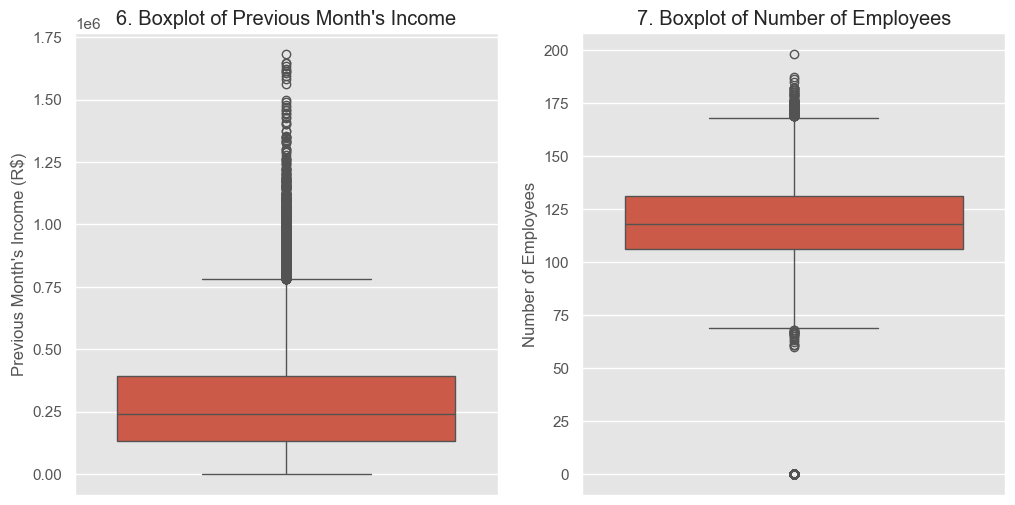

In [589]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Boxplot for RENDA_MES_ANTERIOR
sns.boxplot(data=df_info['RENDA_MES_ANTERIOR'], ax=axs[0])
axs[0].set_title("6. Boxplot of Previous Month's Income")
axs[0].set_ylabel("Previous Month's Income (R$)")

# Boxplot for NO_FUNCIONARIOS
sns.boxplot(data=df_info['NO_FUNCIONARIOS'], ax=axs[1])
axs[1].set_title('7. Boxplot of Number of Employees')
axs[1].set_ylabel("Number of Employees")

plt.show()

In [590]:
print(f'{((df_info[df_info['NO_FUNCIONARIOS'] == 0]['ID_CLIENTE'].unique().shape[0])/df_info.shape[0])*100:.2f}% of the clients have zero employees.')

0.27% of the clients have zero employees.


We can't have clients with zero employees and plot 7 shows some outliers. Therefor, we will use the median to replace the zeros.

In [591]:
# Calculate the median of the NO_FUNCIONARIOS column, ignoring zeros
median_funcionarios = df_info[df_info['NO_FUNCIONARIOS'] != 0]['NO_FUNCIONARIOS'].median()
mean_funcionarios = df_info[df_info['NO_FUNCIONARIOS'] != 0]['NO_FUNCIONARIOS'].mean()
print(f'Median = {median_funcionarios}, mean = {mean_funcionarios:.2f}.')

# Replace zeros in the NO_FUNCIONARIOS column with the median
df_info['NO_FUNCIONARIOS'] = df_info['NO_FUNCIONARIOS'].replace(0, median_funcionarios)

Median = 118.0, mean = 118.91.


In [592]:
# Verify the replacement by checking if there are still any zeros
zero_count_after_replacement = (df_info['NO_FUNCIONARIOS'] == 0).sum()
zero_count_after_replacement

np.int64(0)

In [593]:
# Create a new feature: log of the previous month's income
df_info['RENDA_MES_ANTERIOR_LOG'] = np.log1p(df_info['RENDA_MES_ANTERIOR'])

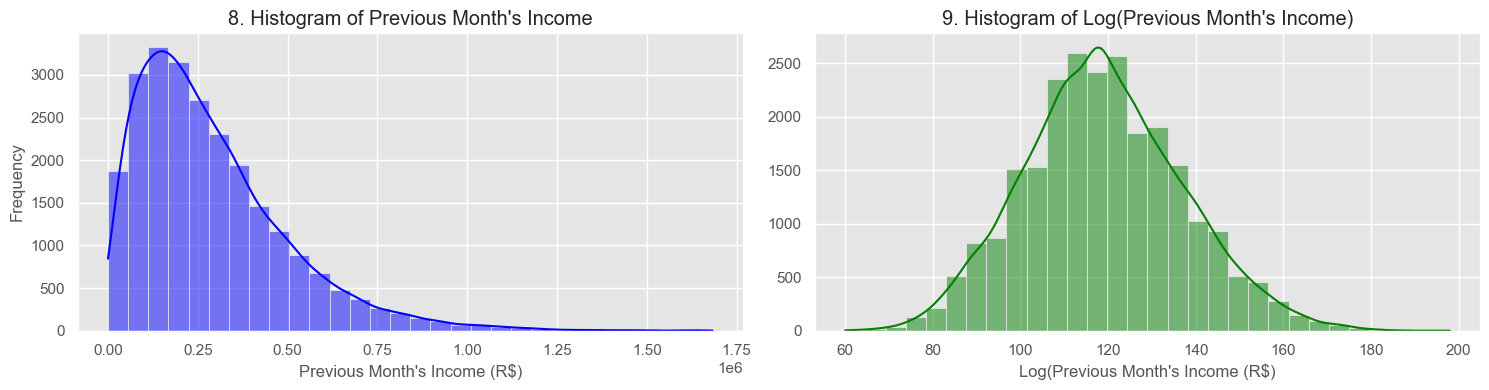

In [594]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

# Create a histogram for RENDA_MES_ANTERIOR
sns.histplot(df_info['RENDA_MES_ANTERIOR'], bins=30, color='blue', kde=True, stat='count', ax=axes[0])
axes[0].set_title("8. Histogram of Previous Month's Income")
axes[0].set_xlabel("Previous Month's Income (R$)")
axes[0].set_ylabel('Frequency')

# Create a histogram for NO_FUNCIONARIOS
sns.histplot(df_info['NO_FUNCIONARIOS'], bins=30, color='green', kde=True, stat='count', ax=axes[1])
axes[1].set_title("9. Histogram of Log(Previous Month's Income)")
axes[1].set_xlabel("Log(Previous Month's Income (R$)")
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

Plot 8 shows that the Previous Month's Income is skewed. Hence, we applied Log to it and used it as a new feature—see plot 9 for Previous Month's Income new distribution.

In [595]:
# Drop skewed 'RENDA_MES_ANTERIOR'
df_info = df_info.drop(columns=['RENDA_MES_ANTERIOR']).copy()

In [596]:
# print(f'{clean_folder}')

# # Save the cleaned dataframe
# df_info.to_csv(clean_folder / 'df_info_clean.csv', index=False)
# pd.read_csv(clean_folder / 'df_info_clean.csv')

# <span style="color:orange">**3. Tables 'Pagamentos Treino' & 'Pagamentos Teste'**</span>

In [597]:
df_pag_train[['VALOR_A_PAGAR', 'TAXA']].describe(), df_pag_test[['VALOR_A_PAGAR', 'TAXA']].describe()

(       VALOR_A_PAGAR          TAXA
 count   7.741400e+04  77414.000000
 mean    4.656546e+04      6.789623
 std     4.633892e+04      1.798225
 min     1.000000e-01      4.990000
 25%     1.875275e+04      5.990000
 50%     3.475135e+04      5.990000
 75%     6.088421e+04      6.990000
 max     4.400000e+06     11.990000,
        VALOR_A_PAGAR          TAXA
 count   12275.000000  12275.000000
 mean    65899.369914      6.807271
 std     55874.481691      1.835351
 min         6.900000      4.990000
 25%     26718.375000      5.990000
 50%     49705.010000      5.990000
 75%     87163.295000      6.990000
 max    830000.000000     11.990000)

Both 'VALOR_A_PAGAR' for training and testing are heavily skewed, so we will create two new features using the Log function.

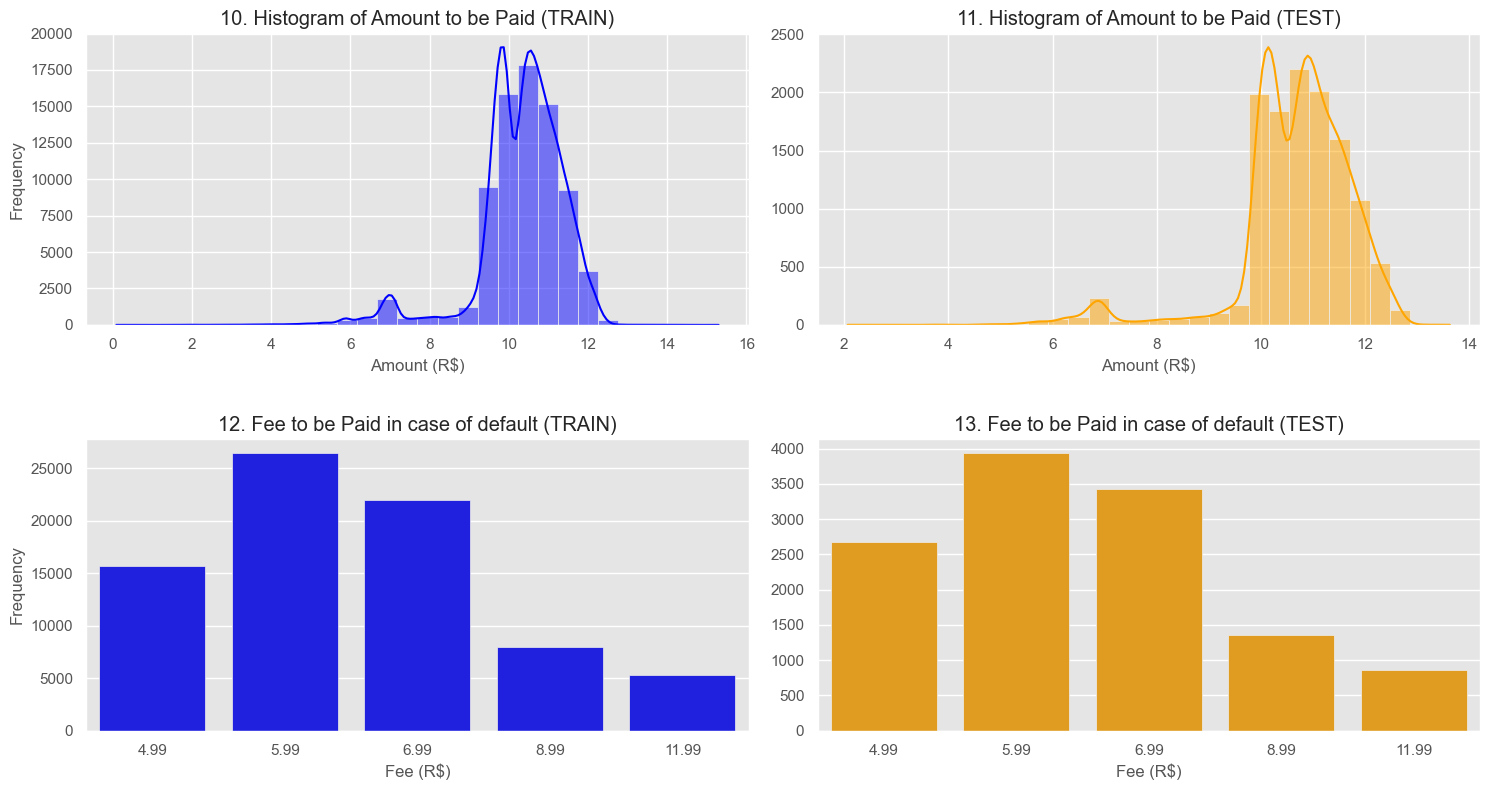

In [598]:
# Apply log transformation (adding a small value to avoid log(0))
df_pag_train['VALOR_A_PAGAR_LOG'] = np.log1p(df_pag_train['VALOR_A_PAGAR'])
df_pag_test['VALOR_A_PAGAR_LOG'] = np.log1p(df_pag_test['VALOR_A_PAGAR'])

fig, axes = plt.subplots(2, 2, figsize=(15, 8))

# Plot the distribution 'VALOR_A_PAGAR' train and test
sns.histplot(df_pag_train['VALOR_A_PAGAR_LOG'], bins=30, color='blue', kde=True, stat='count', ax=axes[0][0])
axes[0][0].set_title('10. Histogram of Amount to be Paid (TRAIN)')
axes[0][0].set_xlabel('Amount (R$)')
axes[0][0].set_ylabel('Frequency')
sns.histplot(df_pag_test['VALOR_A_PAGAR_LOG'], bins=30, color='orange', kde=True, stat='count', ax=axes[0][1])
axes[0][1].set_title('11. Histogram of Amount to be Paid (TEST)')
axes[0][1].set_xlabel('Amount (R$)')
axes[0][1].set_ylabel('')
sns.countplot(data=df_pag_train, x='TAXA', color='blue', ax=axes[1][0])
axes[1][0].set_title('12. Fee to be Paid in case of default (TRAIN)')
axes[1][0].set_xlabel('Fee (R$)')
axes[1][0].set_ylabel('Frequency')
sns.countplot(data=df_pag_test, x='TAXA', color='orange', ax=axes[1][1])
axes[1][1].set_title('13. Fee to be Paid in case of default (TEST)')
axes[1][1].set_xlabel('Fee (R$)')
axes[1][1].set_ylabel('')

plt.tight_layout(h_pad=3)
plt.show()

Default is calculated based on the number of days late in payment. Five days or more is considered default. We will create a new binary-valued column, 'INADIMPLENCIA,' where 1 indicates default.

In [599]:
#  Convert date columns to datetime format
df_pag_train['DATA_EMISSAO_DOCUMENTO'] = pd.to_datetime(df_pag_train['DATA_EMISSAO_DOCUMENTO'])
df_pag_train['DATA_VENCIMENTO'] = pd.to_datetime(df_pag_train['DATA_VENCIMENTO'])
df_pag_train['DATA_PAGAMENTO'] = pd.to_datetime(df_pag_train['DATA_PAGAMENTO'])
# df_pag_train['SAFRA_REF'] = pd.to_datetime(df_pag_train['SAFRA_REF'])
df_pag_test['DATA_EMISSAO_DOCUMENTO'] = pd.to_datetime(df_pag_test['DATA_EMISSAO_DOCUMENTO'])
df_pag_test['DATA_VENCIMENTO'] = pd.to_datetime(df_pag_test['DATA_VENCIMENTO'])
# df_pag_test['SAFRA_REF'] = pd.to_datetime(df_pag_test['SAFRA_REF'])

In [600]:
# Create the 'INADIMPLENTE' target variable: difference >= 5 days indicates default
df_pag_train['DIAS_ATRASO'] = (df_pag_train['DATA_PAGAMENTO'] - df_pag_train['DATA_VENCIMENTO']).dt.days
df_pag_train['INADIMPLENTE'] = df_pag_train['DIAS_ATRASO'].apply(lambda x: 1 if x >= 5 else 0)

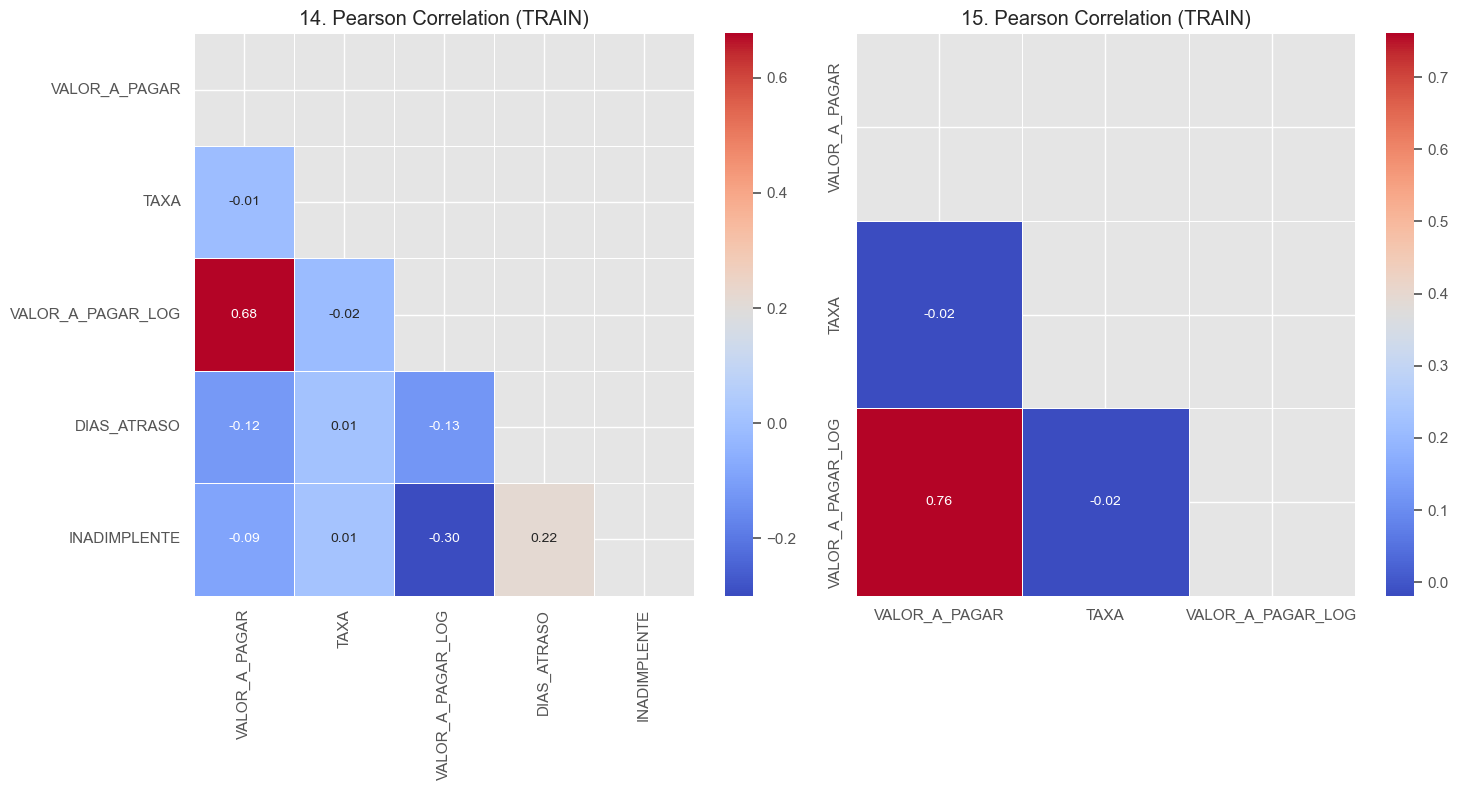

In [601]:
# Selecting only numeric columns and create correlation tables
numeric_cols_test = df_pag_test.drop(columns=['ID_CLIENTE']).select_dtypes(include=['float64', 'int64']).columns
pear_corr_test = df_pag_test[numeric_cols_test].corr()
numeric_cols_train = df_pag_train.drop(columns=['ID_CLIENTE']).select_dtypes(include=['float64', 'int64']).columns
pear_corr_train = df_pag_train[numeric_cols_train].corr()

fig, axs = plt.subplots(1, 2, figsize=(15, 8))
mask0 = np.triu(np.ones_like(pear_corr_train, dtype=bool))
sns.heatmap(pear_corr_train, mask=mask0, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, ax=axs[0])
axs[0].set_title('14. Pearson Correlation (TRAIN)')
axs[0].set_xlabel('')
axs[0].set_ylabel('')

mask1 = np.triu(np.ones_like(pear_corr_test, dtype=bool))
sns.heatmap(pear_corr_test, mask=mask1, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, ax=axs[1])
axs[1].set_title('15. Pearson Correlation (TRAIN)')
axs[1].set_xlabel('')
axs[1].set_ylabel('')


plt.tight_layout()
plt.show()

The engineered features can replace their original features. For both train and test data, 'VALOR_A_PAGAR' and 'VALOR_A_PAGAR_LOG' show a strong correlation. Including both could introduce multicollinearity, which can lead to redundancy and potentially impact model interpretability and performance. 

We will also drop 'DIAS_ATRASO' since this column depends on the date on which the due amount was paid, and we don't have this information in the test data.

In [602]:
df_pag_train = df_pag_train.drop(columns=['VALOR_A_PAGAR', 'DIAS_ATRASO']).copy()
df_pag_test = df_pag_test.drop(columns=['VALOR_A_PAGAR']).copy()

In [603]:
# # print(f'{clean_folder}')

# # Save the cleaned dataframe
# df_pag_train.to_csv(clean_folder / 'df_pag_train_clean.csv', index=False)
# df_pag_test.to_csv(clean_folder / 'df_pag_test_clean.csv', index=False)
# pd.read_csv(clean_folder / 'df_pag_train_clean.csv')
# pd.read_csv(clean_folder / 'df_pag_test_clean.csv')

# <span style="color:orange">**4. Merging tables 'Info' and 'Cad'**</span>

In [604]:
# Merge Base Info and Base Cadastral on 'ID_CLIENTE' with indicator=True
df_info_cad = pd.merge(df_info, df_cad, on='ID_CLIENTE', how='outer', indicator=True).copy()

# Check the breakdown of where the data comes from
print(df_info_cad['_merge'].value_counts())

n_left = df_info_cad[df_info_cad['_merge']=='left_only'].shape[0]
n_total_info = df_info_cad.shape[0]
print(f'\nApproximately  {((n_total_info-n_left)/n_total_info):.2f}% of companies in table Info were not registered.')

_merge
both          24147
left_only       254
right_only        0
Name: count, dtype: int64

Approximately  0.99% of companies in table Info were not registered.


In [605]:
df_info_cad[df_info_cad['_merge'] == 'left_only'].drop('ID_CLIENTE', axis=1).describe()

,NO_FUNCIONARIOS,RENDA_MES_ANTERIOR_LOG
count,254.000000,254.000000
mean,118.141732,10.081102
std,4.727724,1.227860
min,98.000000,5.043425
25%,118.000000,9.392699
50%,118.000000,10.015588
75%,118.000000,10.696026
max,158.000000,13.508567


In [606]:
# Encode the categorical feature
le = LabelEncoder()
df_info_cad['SEGMENTO_dummy'] = le.fit_transform(df_info_cad['SEGMENTO_INDUSTRIAL'].fillna('Missing'))
df_info_cad['PORTE_dummy'] = le.fit_transform(df_info_cad['PORTE'].fillna('Missing'))
df_info_cad['REGIAO_dummy'] = le.fit_transform(df_info_cad['REGIAO'].fillna('Missing'))
df_info_cad['ESTADO_dummy'] = le.fit_transform(df_info_cad['ESTADO'].fillna('Missing'))

In [607]:
df_info_cad[df_info_cad['PORTE'].isnull()].head()

,ID_CLIENTE,SAFRA_REF,NO_FUNCIONARIOS,RENDA_MES_ANTERIOR_LOG,SEGMENTO_INDUSTRIAL,PORTE,ESTADO,REGIAO,_merge,SEGMENTO_dummy,PORTE_dummy,REGIAO_dummy,ESTADO_dummy
115,51762959302415533,2021-10,103.0,11.541425,NaN,NaN,NaN,NaN,left_only,2,1,1,12
116,51762959302415533,2021-11,103.0,13.205025,NaN,NaN,NaN,NaN,left_only,2,1,1,12
488,189650789135045122,2019-12,118.0,9.096948,NaN,NaN,NaN,NaN,left_only,2,1,1,12
489,189650789135045122,2020-03,118.0,8.178077,NaN,NaN,NaN,NaN,left_only,2,1,1,12
490,189650789135045122,2020-09,118.0,9.519001,NaN,NaN,NaN,NaN,left_only,2,1,1,12


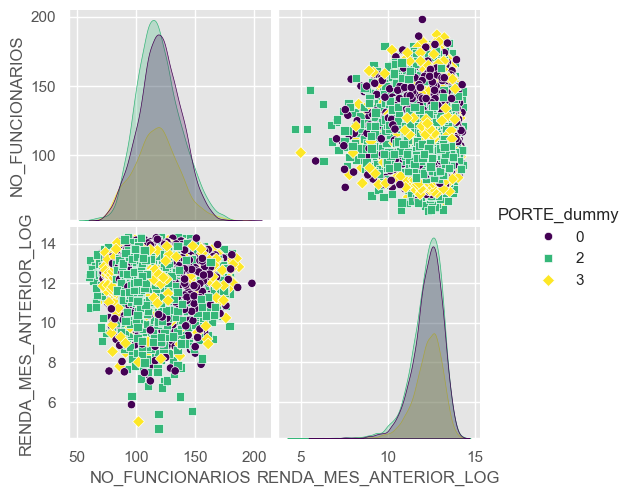

In [608]:
sns.pairplot(df_info_cad[df_info_cad['PORTE_dummy'] != 1][['NO_FUNCIONARIOS', 'RENDA_MES_ANTERIOR_LOG', 'PORTE_dummy']], hue='PORTE_dummy', markers=["o", "s", "D"], palette='viridis')

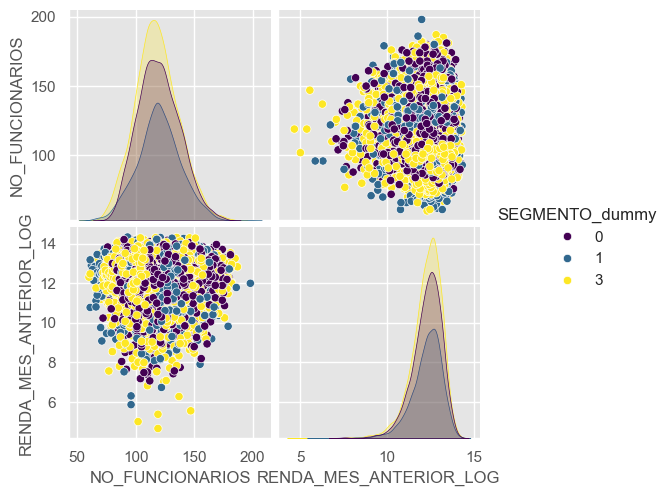

In [609]:
sns.pairplot(df_info_cad[df_info_cad['SEGMENTO_dummy'] != 2][['NO_FUNCIONARIOS', 'RENDA_MES_ANTERIOR_LOG', 'SEGMENTO_dummy']], hue='SEGMENTO_dummy', palette='viridis')

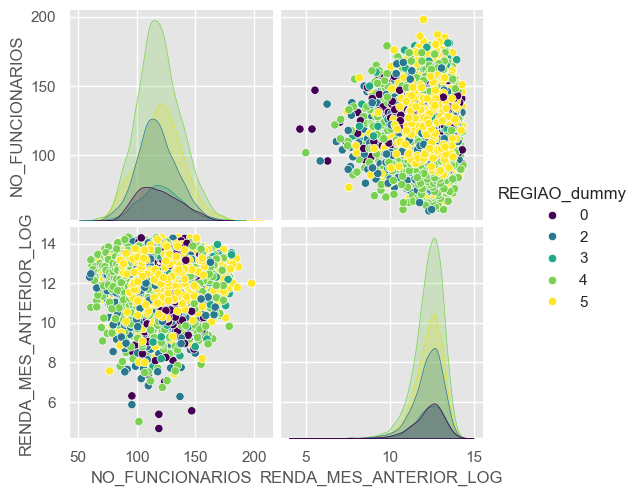

In [610]:
sns.pairplot(df_info_cad[df_info_cad['REGIAO_dummy'] != 1][['NO_FUNCIONARIOS', 'RENDA_MES_ANTERIOR_LOG', 'REGIAO_dummy']], hue='REGIAO_dummy', palette='viridis')

The pair plots don't show any particular pattern that we could use in the imputation of missing values, and these missing values represent a small fraction of the data. Therefor dropping these records is a reasonable choice, especially considering the lack of strong imputation options and the minimal impact on your dataset size. This will keep your data cleaner and avoid potential biases or inaccuracies from forced imputation.

In [611]:
# Drops missing values for 'PORTE', 'SEGMENTO' and 'REGIAO'
df_info_cad = df_info_cad.dropna(subset=['PORTE', 'REGIAO', 'SEGMENTO_INDUSTRIAL']).copy()

In [612]:
# Check for missing values
df_info_cad.isna().sum()

ID_CLIENTE                0
SAFRA_REF                 0
NO_FUNCIONARIOS           0
RENDA_MES_ANTERIOR_LOG    0
SEGMENTO_INDUSTRIAL       0
PORTE                     0
ESTADO                    0
REGIAO                    0
_merge                    0
SEGMENTO_dummy            0
PORTE_dummy               0
REGIAO_dummy              0
ESTADO_dummy              0
dtype: int64

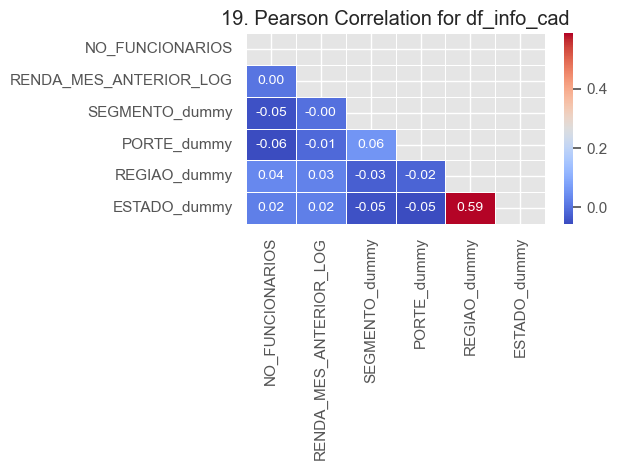

In [613]:
# Selecting only numeric columns and create correlation tables
numeric_cols = df_info_cad.drop(columns=['ID_CLIENTE']).select_dtypes(include=['float64', 'int64']).columns
pear_corr = df_info_cad[numeric_cols].corr()

mask = np.triu(np.ones_like(pear_corr, dtype=bool))
sns.heatmap(pear_corr, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('19. Pearson Correlation for df_info_cad')
# axs[0].set_xlabel('')
# axs[0].set_ylabel('')


plt.tight_layout()
plt.show()

ESTADO and REGIAO have a correlation, so we will keep only 'ESTADO' since it is more granular.

In [614]:
# Drop REGIAO columns
df_info_cad = df_info_cad.drop(['REGIAO', 'REGIAO_dummy', '_merge'], axis=1).copy()

In [615]:
# print(f'{clean_folder}')

## Save the cleaned dataframe
# df_info_cad.to_csv(clean_folder / 'df_info_cad_merge.csv', index=False)
# pd.read_csv(clean_folder / 'df_info_cad_merge.csv')

# <span style="color:orange">**4. Merging tables 'Info' and 'Cad'**</span>

We can't make any imputations for the testing data, so we will make an inner merge and consequently drop all missing values.

In [618]:
# Inner merge for testing data
df_test = pd.merge(df_info_cad, df_pag_test, on=['ID_CLIENTE', 'SAFRA_REF'], how='inner')
df_test.isna().sum()

ID_CLIENTE                0
SAFRA_REF                 0
NO_FUNCIONARIOS           0
RENDA_MES_ANTERIOR_LOG    0
SEGMENTO_INDUSTRIAL       0
PORTE                     0
ESTADO                    0
SEGMENTO_dummy            0
PORTE_dummy               0
ESTADO_dummy              0
DATA_EMISSAO_DOCUMENTO    0
DATA_VENCIMENTO           0
TAXA                      0
VALOR_A_PAGAR_LOG         0
dtype: int64

In [ ]:
# print(f'{clean_folder}')

# # Save the cleaned dataframe
# df_test.to_csv(clean_folder / 'df_test.csv', index=False)

In [ ]:
# Create traing data
df_train = pd.merge(df_info_cad, df_pag_train, on=['ID_CLIENTE', 'SAFRA_REF'], how='right', indicator=True)
df_train.isna().sum()

ID_CLIENTE                   0
SAFRA_REF                    0
NO_FUNCIONARIOS           4093
RENDA_MES_ANTERIOR_LOG    4093
SEGMENTO_INDUSTRIAL       4093
PORTE                     4093
ESTADO                    4093
SEGMENTO_dummy            4093
PORTE_dummy               4093
ESTADO_dummy              4093
DATA_EMISSAO_DOCUMENTO       0
DATA_PAGAMENTO               0
DATA_VENCIMENTO              0
TAXA                         0
VALOR_A_PAGAR_LOG            0
INADIMPLENTE                 0
_merge                       0
dtype: int64

In [ ]:
df_train['']

In [ ]:
df_train = df_train.copy()

numeric_cols = df_train.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = df_train.select_dtypes(include=['object']).columns

num_imputer = SimpleImputer(strategy='median')
df_train[numeric_cols] = num_imputer.fit_transform(df_train[numeric_cols])

cat_imputer = SimpleImputer(strategy='most_frequent')
df_train[categorical_cols] = cat_imputer.fit_transform(df_train[categorical_cols])

In [ ]:
# print(f'{clean_folder}')

# # Save the cleaned dataframe
# df_test.to_csv(clean_folder / 'df_test.csv', index=False)

In [ ]:
df_train.isna().sum()

ID_CLIENTE                0
SAFRA_REF                 0
RENDA_MES_ANTERIOR        0
NO_FUNCIONARIOS           0
RENDA_MES_ANTERIOR_LOG    0
SEGMENTO_INDUSTRIAL       0
PORTE                     0
ESTADO                    0
REGIAO                    0
DATA_EMISSAO_DOCUMENTO    0
DATA_PAGAMENTO            0
DATA_VENCIMENTO           0
VALOR_A_PAGAR             0
TAXA                      0
VALOR_A_PAGAR_LOG         0
DIAS_ATRASO               0
INADIMPLENTE              0
dtype: int64

In [ ]:
df_train = utils.consistent_dates(df_train, test=False).copy()
df_test = utils.consistent_dates(df_test, test=True).copy()

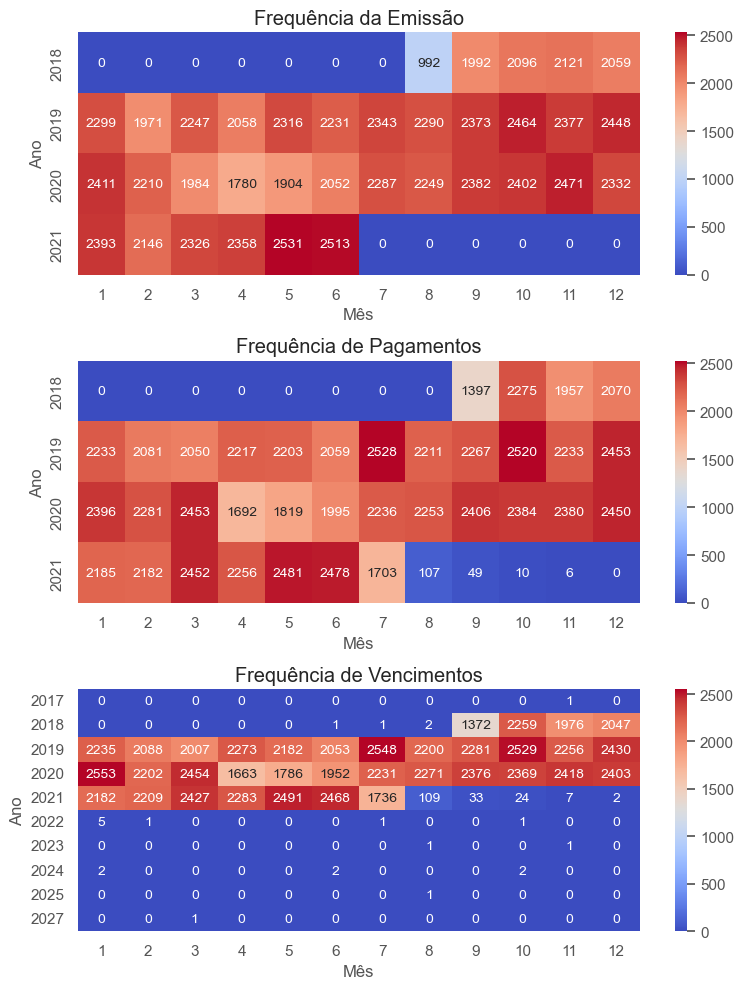

In [ ]:
data = df_train.copy()

# Extract year and month from 'DATA_EMISSAO_DOCUMENTO' and 'DATA_VENCIMENTO'
data['emissao_year'] = data['DATA_EMISSAO_DOCUMENTO'].dt.year
data['emissao_month'] = data['DATA_EMISSAO_DOCUMENTO'].dt.month
data['vencimento_year'] = data['DATA_VENCIMENTO'].dt.year
data['vencimento_month'] = data['DATA_VENCIMENTO'].dt.month
data['pagamento_year'] = data['DATA_PAGAMENTO'].dt.year
data['pagamento_month'] = data['DATA_PAGAMENTO'].dt.month

# Create pivot tables for each date type
heatmap_emissao = data.pivot_table(index='emissao_year', columns='emissao_month', aggfunc='size', fill_value=0)
heatmap_vencimento = data.pivot_table(index='vencimento_year', columns='vencimento_month', aggfunc='size', fill_value=0)
heatmap_pagamento = data.pivot_table(index='pagamento_year', columns='pagamento_month', aggfunc='size', fill_value=0)

# Plotting the 3 heatmaps as subplots
fig, axes = plt.subplots(3, 1, figsize=(8, 10))

# Heatmap for DATA_EMISSAO_DOCUMENTO
sns.heatmap(heatmap_emissao, cmap="coolwarm", annot=True, fmt="d", ax=axes[0])
axes[0].set_title('Frequência da Emissão')
axes[0].set_xlabel('Mês')
axes[0].set_ylabel('Ano')

# Heatmap for DATA_PAGAMENTO
sns.heatmap(heatmap_pagamento, cmap="coolwarm", annot=True, fmt="d", ax=axes[1])
axes[1].set_title('Frequência de Pagamentos')
axes[1].set_xlabel('Mês')
axes[1].set_ylabel('Ano')

# Heatmap for DATA_VENCIMENTO
sns.heatmap(heatmap_vencimento, cmap="coolwarm", annot=True, fmt="d", ax=axes[2])
axes[2].set_title('Frequência de Vencimentos')
axes[2].set_xlabel('Mês')
axes[2].set_ylabel('Ano')

plt.tight_layout()
plt.show()

A frequência de pagamentos e vencimentos ao longo do tempo parece bem próxima. Isso provalmente significa que, nesse banco de dados, os clientes pagam perto do vencimento.

In [ ]:
# print(f'{clean_folder}')

# Save the cleaned dataframe
df_train.to_csv(clean_folder / 'df_train0.csv', index=False)
df_test.to_csv(clean_folder / 'df_test0.csv', index=False)